# Задача Кредитного скоринга. Целевая Метрика AUC .

In [185]:

import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import pylab as pl


import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns



from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss

In [186]:
file_full_path_training = '/GiveMeSomeCredit-training (1) (1).csv'

In [187]:
train_df = pd.read_csv(file_full_path_training)

# SeriousDlqin2yrs переменная является таргетом. Принимает дискретные значение 1 или 0

In [188]:
train_df

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [189]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

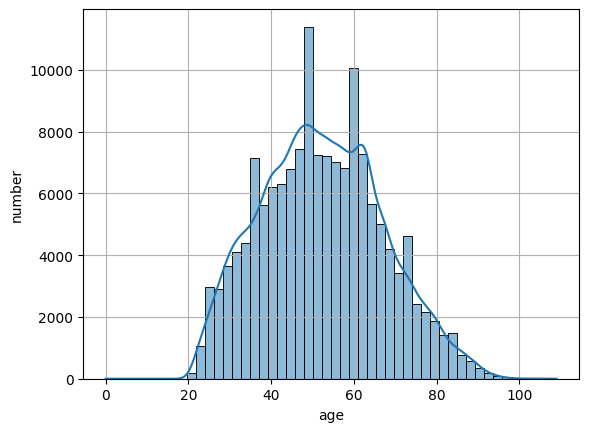

In [190]:
sns.histplot(train_df['age'], kde=True, bins = 50)
plt.xlabel('age')
plt.ylabel('number')
plt.grid()
plt.show()

In [191]:
train_df[train_df['age'] < 18]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


# Есть явно выброс по переменной 'age'. Варианты действий:

1.   Создать новую фичу Выброс/нет (Глупо для одного объекта)
2.   Заполнить нулем (Тоже плохо)
3.   Заполнить медианой или средним значением по столбцу (Неплохо)
4.   **Удалить этот объект (Выбираю этот вариант, так как всего лишь один объект, потеря несущественна) **





In [192]:
train_df = train_df[train_df['age'] >= 18]

In [193]:
def density_show(data):
  sns.histplot(data, kde=True, bins = 50)
  plt.xlabel(f'{data.name}')
  plt.ylabel('number')
  plt.grid()

# Отрисовка Плотности распределения объектов по каждой фиче

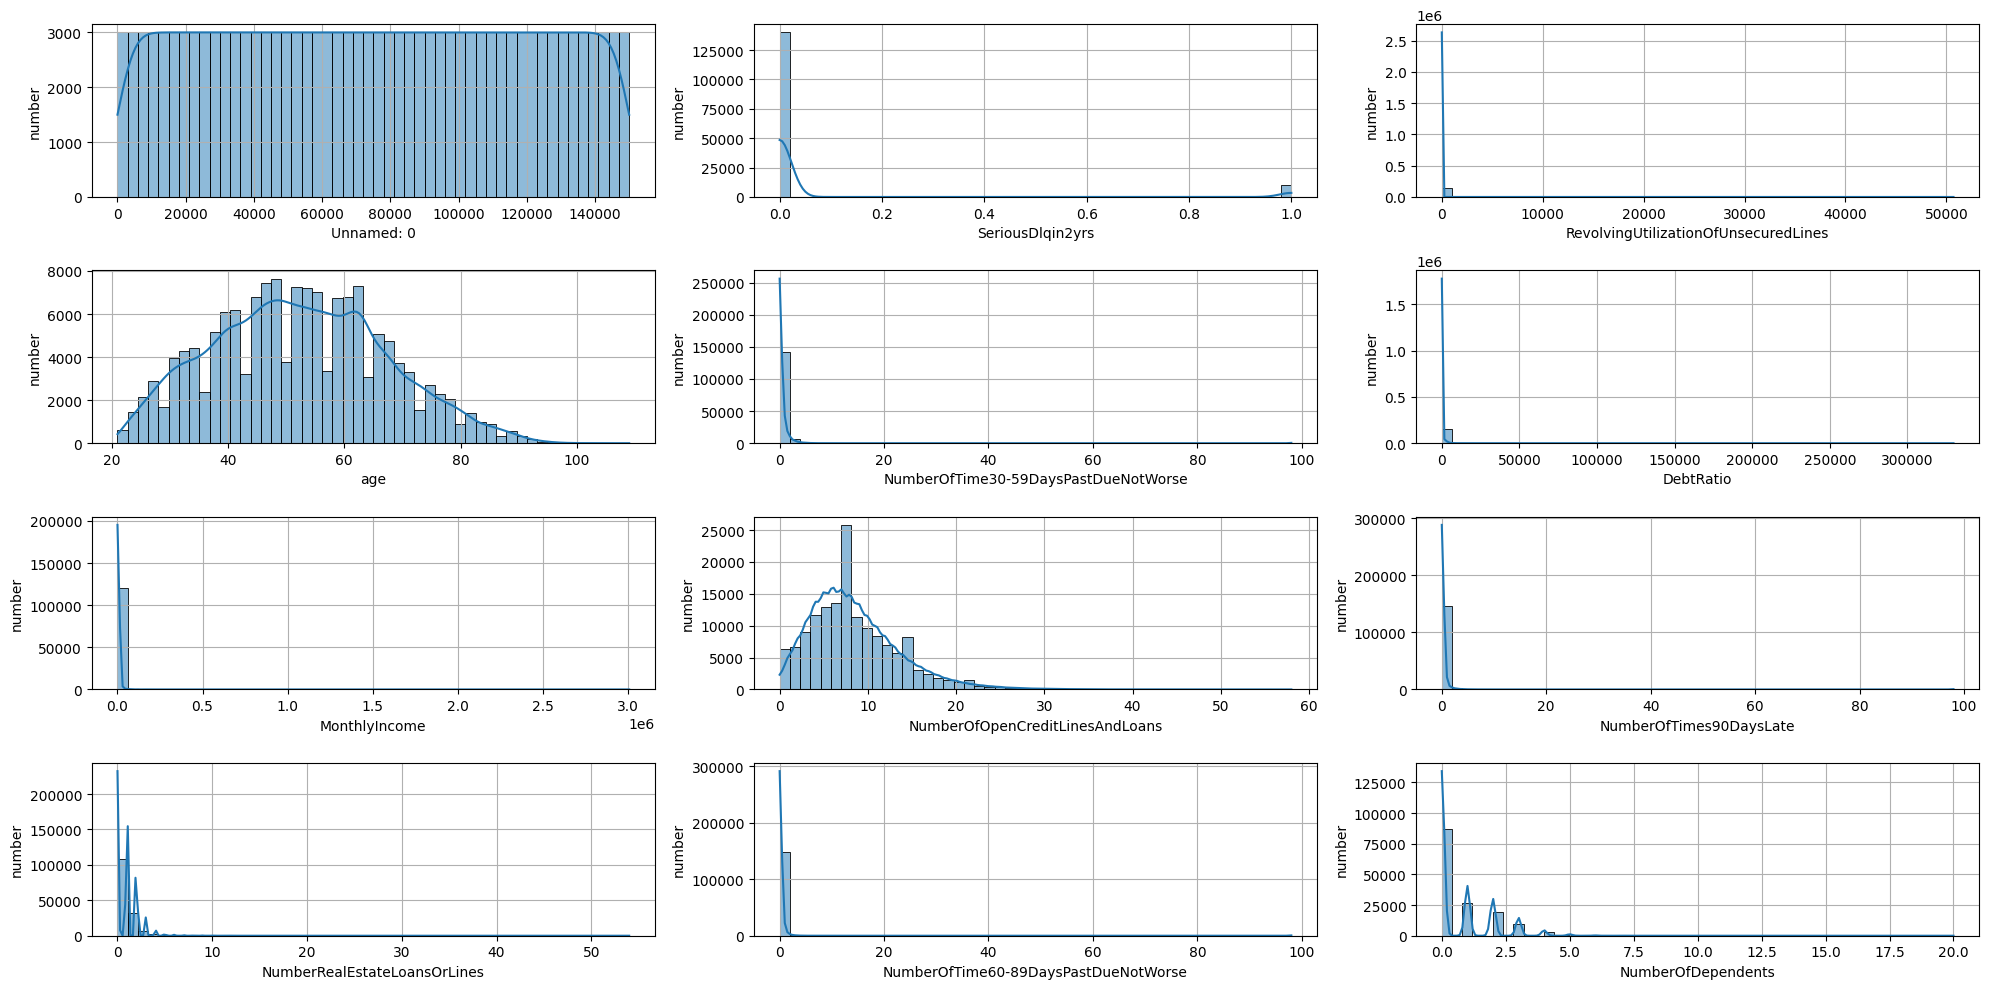

In [194]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20, 10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        density_show(df[var_name])

    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


draw_histograms(train_df, train_df.columns, 4, 3)

In [195]:
def createCorrelationHeatMap(data):
    corr = data.corr()
    fig = plt.figure(figsize=(10,10))
    ax = sns.heatmap(corr, annot=True, fmt='.2f', cmap = "RdBu_r",xticklabels=True, yticklabels=True, cbar=True)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

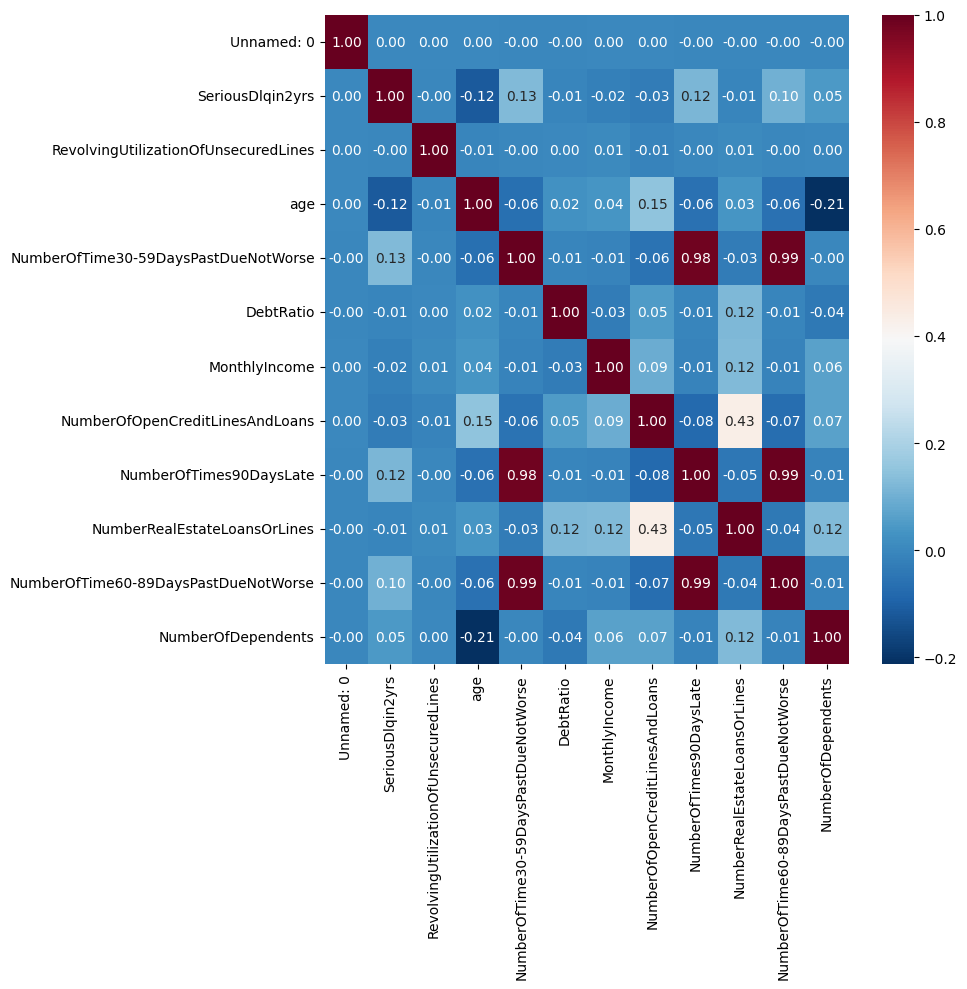

In [196]:
createCorrelationHeatMap(train_df)

# Посмотрим на взаимное распределение по фичам.

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


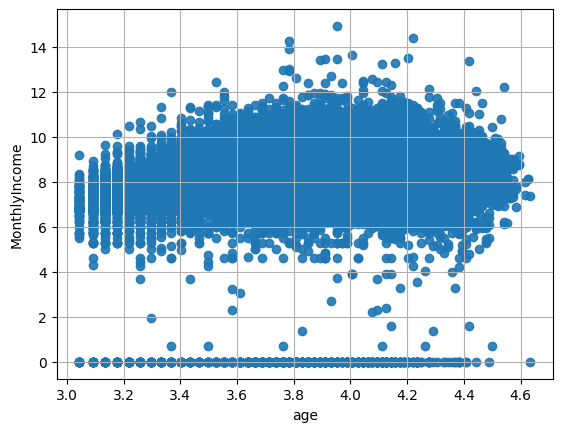

In [197]:
plt.scatter(np.log(train_df['age']), np.log(train_df['MonthlyIncome']), alpha=0.9)
plt.xlabel('age')
plt.ylabel('MonthlyIncome')
plt.grid()
plt.show()

In [198]:
train_df['MonthlyIncome'].describe()

,MonthlyIncome
count,1.202680e+05
mean,6.670227e+03
std,1.438473e+04
min,0.000000e+00
25%,3.400000e+03
50%,5.400000e+03
75%,8.249000e+03
max,3.008750e+06


In [199]:
train_df.isnull().sum()

,0
Unnamed: 0,0
SeriousDlqin2yrs,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,29731
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0


# Заполняем пропуски медианным значение, наиболее подходящее заполнение

In [200]:
train_df.loc[:, 'MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
train_df.loc[:, 'NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())

In [201]:
train_df.rename(columns={'SeriousDlqin2yrs': 'target', 'Unnamed: 0': 'Id'}, inplace=True)

<ipython-input-201-f71f7ade1ae2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns={'SeriousDlqin2yrs': 'target', 'Unnamed: 0': 'Id'}, inplace=True)


In [202]:
train_df

,Id,target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,5400.0,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


# Начнем Обучать модели

In [203]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns = ['target', 'Id']), train_df['target'], test_size=0.2, random_state=42)

In [204]:
y_train

,target
104026,0
5415,0
75613,0
138169,0
87185,0
...,...
119880,0
103695,1
131933,0
146868,0


In [205]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [206]:
def plot_roc_curve(false_positive_rate, true_positive_rate, label="ROC Curve"):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    plt.plot(false_positive_rate, true_positive_rate, linewidth=1)
    plt.plot([0,1],[0,1], "r--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")

    title_obj = ax.set_title(label)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.grid(linestyle='--')
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


# Попробуем LogisticRegression. Выбираю L1 регуляризацию так как много фичей имеют нулевую корреляцию с таргетом. (L1 'отбирает' фичи). Использую С=1.0 умеренная регуляризация. Использую saga так как имеем много объектов (из соображений скорости).

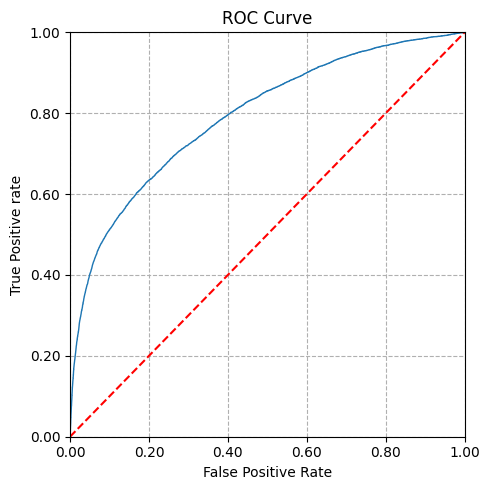

0.7931261373512468
AUC Score_train :  0.7931261


In [207]:
import sklearn.metrics as metrics

model_log_reg_saga = LogisticRegression(random_state=42, penalty='l1', solver='saga', class_weight = 'balanced', C=1.0, max_iter=500)
model_log_reg_saga.fit(X_train_scaled, y_train)
y_pred_1 = model_log_reg_saga.predict_proba(X_train_scaled)
preds = y_pred_1[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
plot_roc_curve(fpr,tpr)
roc_auc = metrics.auc(fpr, tpr)

print(roc_auc)
print('AUC Score_train : ', round(roc_auc_score(y_train,preds),7))

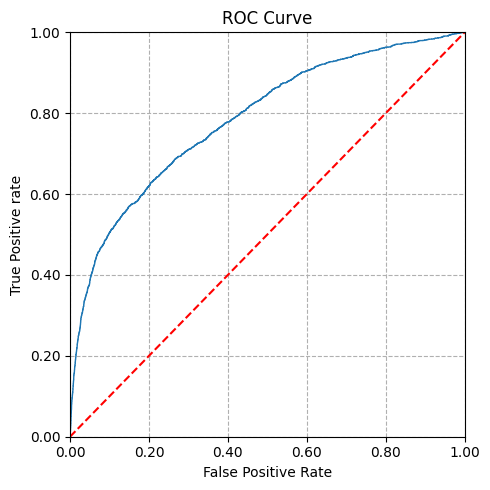

0.7853929851386758
AUC Score_test_log_reg :  0.785393


In [208]:
y_pred_1_test = model_log_reg_saga.predict_proba(X_test_scaled)
y_test_log_reg = y_pred_1_test[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_log_reg)
plot_roc_curve(fpr,tpr)
roc_auc = metrics.auc(fpr, tpr)

print(roc_auc)
print('AUC Score_test_log_reg : ', round(roc_auc_score(y_test,y_test_log_reg),7))

# Попробуем KNN с разными метриками расстояния




In [209]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier



knn_manhattan = KNeighborsClassifier(n_neighbors=20, metric='manhattan')
knn_cosine = KNeighborsClassifier(n_neighbors=20, metric='cosine')
knn_euclidean = KNeighborsClassifier(n_neighbors=20, metric='euclidean')
knn_chebyshev = KNeighborsClassifier(n_neighbors=20, metric='chebyshev')


# Обучение модели с различным выбором метрики
knn_manhattan.fit(X_train_scaled, y_train)
knn_cosine.fit(X_train_scaled, y_train)
knn_euclidean.fit(X_train_scaled, y_train)
knn_chebyshev.fit(X_train_scaled, y_train)

y_manhattan = knn_manhattan.predict_proba(X_test_scaled)[:,1]
y_cosine = knn_cosine.predict_proba(X_test_scaled)[:,1]
y_euclidean = knn_euclidean.predict_proba(X_test_scaled)[:,1]
y_chebyshev = knn_chebyshev.predict_proba(X_test_scaled)[:,1]


In [210]:
print(f'roc_auc_score_cosine: {roc_auc_score(y_test, y_cosine)}')
print(f'roc_auc_score_manhattan: {roc_auc_score(y_test, y_manhattan)}')
print(f'roc_auc_score_euclidan: {roc_auc_score(y_test, y_euclidean)}')
print(f'roc_auc_score_chebyshev: {roc_auc_score(y_test, y_chebyshev)}')

roc_auc_score_cosine: 0.7484896368565835
roc_auc_score_manhattan: 0.7299475833161166
roc_auc_score_euclidan: 0.7352333696307269
roc_auc_score_chebyshev: 0.7540431071187801


# Лучшая метрика расстояния - Чебышева

Метрика Чебышева (или максимальная метрика) — это способ измерения расстояния между двумя точками в пространстве, который определяется как максимальное значение абсолютных разностей между соответствующими координатами этих точек.

Формально, расстояние Чебышева между двумя точками $ p $ и $ q $ в n-мерном пространстве определяется как:

$$d(p, q) = \max(|p_1 - q_1|, |p_2 - q_2|, \ldots, |p_n - q_n|)$$

где $ p_i $ и $ q_i $ — координаты точек $ p $ и $ q $.

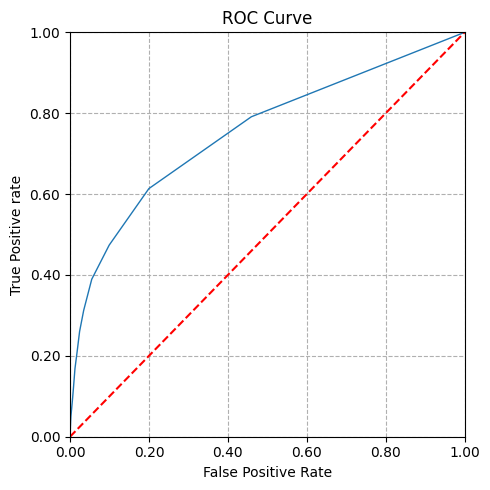

AUC Score_test_KNN: 0.7540431071187801


In [211]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_chebyshev)
plot_roc_curve(fpr,tpr)
roc_auc_KNN_chebyshev = metrics.auc(fpr, tpr)
print(f'AUC Score_test_KNN: {roc_auc_KNN_chebyshev}' )

In [212]:
!pip install catboost


# Реализуем CatBoost
Подобрал оптимальный learning_rate и глубину деревьев


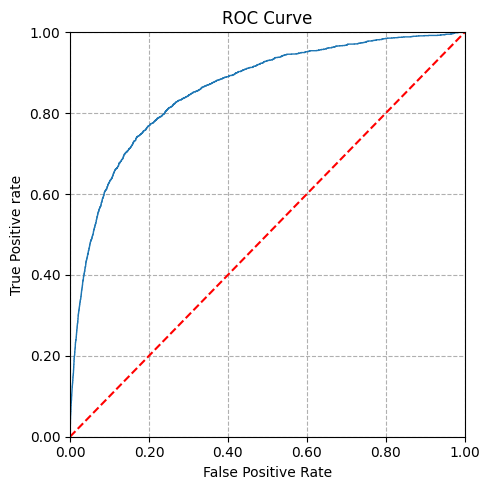

AUC Score_test_CatBoost: 0.8592693


In [213]:
from catboost  import CatBoostClassifier

model_catboost = CatBoostClassifier(iterations=100, learning_rate=0.3, depth=4, verbose = 0)
model_catboost.fit(X_train_scaled, y_train)
y_pred_catboost = model_catboost.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_catboost)
plot_roc_curve(fpr,tpr)
roc_auc_test_catboost = round(roc_auc_score(y_test,y_pred_catboost),7)
print(f'AUC Score_test_CatBoost: {roc_auc_test_catboost}' )

# Реализуем RandomForest


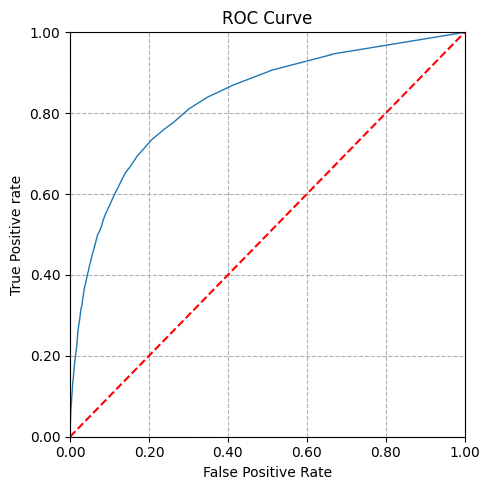

AUC Score_test_rf: 0.8326144


In [214]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_rf_test = rf.predict_proba(X_test_scaled)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_rf_test)
plot_roc_curve(fpr,tpr)
roc_auc_test_rf = round(roc_auc_score(y_test,y_rf_test),7)
print(f'AUC Score_test_rf: {roc_auc_test_rf}' )

# Реализуем Градиентный Бустинг

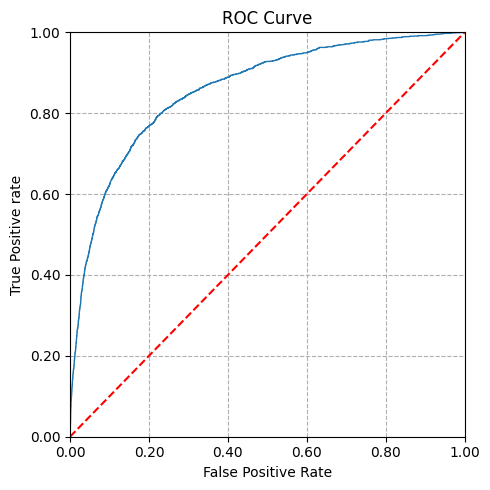

AUC Score_GradientBoostingClassifier_test :  0.8586128959893354


In [215]:
clf = GradientBoostingClassifier( random_state=42, n_estimators=150, learning_rate=0.05, max_depth=5)
clf.fit(X_train_scaled, y_train)
clf_scores_proba = clf.predict_proba(X_test_scaled)    # Predict class probabilities for X.
y_GBC_test = clf_scores = clf_scores_proba[::,1]
fpr, tpr, thresh = roc_curve(y_test, y_GBC_test)
plot_roc_curve(fpr,tpr)
print('AUC Score_GradientBoostingClassifier_test : ', (roc_auc_score(y_test,y_GBC_test)))

# Сравнение всех моделей

In [216]:
print('AUC Score_test_GBC:', round(roc_auc_score(y_test, y_GBC_test), 7))
print('\n')
print('AUC Score_test_rf:', round(roc_auc_test_rf, 7))
print('\n')
print('AUC Score_test_CatBoost:', round(roc_auc_test_catboost, 7))
print('\n')
print('AUC Score_test_KNN:', round(roc_auc_KNN_chebyshev, 7))
print('\n')
print('AUC Score_test_log_reg:', round(roc_auc_score(y_test, y_test_log_reg), 7))


AUC Score_test_GBC: 0.8586129


AUC Score_test_rf: 0.8326144


AUC Score_test_CatBoost: 0.8592693


AUC Score_test_KNN: 0.7540431


AUC Score_test_log_reg: 0.785393


# **CatBoost наилучший Score: 0.8592693**